In [7]:
from ssdmultibox.datasets import TrainPascalDataset
from fastai.dataset import open_image
import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches, patheffects

np.set_printoptions(precision=15)

In [8]:
dataset = TrainPascalDataset(grid_size=4)

In [9]:
from ssdmultibox.plotting import plot_single, plot_multiple

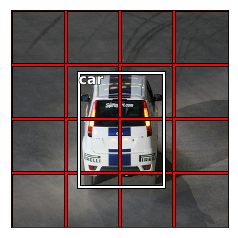

In [10]:
plot_single(dataset, 0)

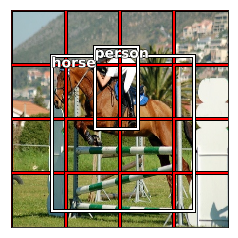

In [11]:
plot_single(dataset, 1)

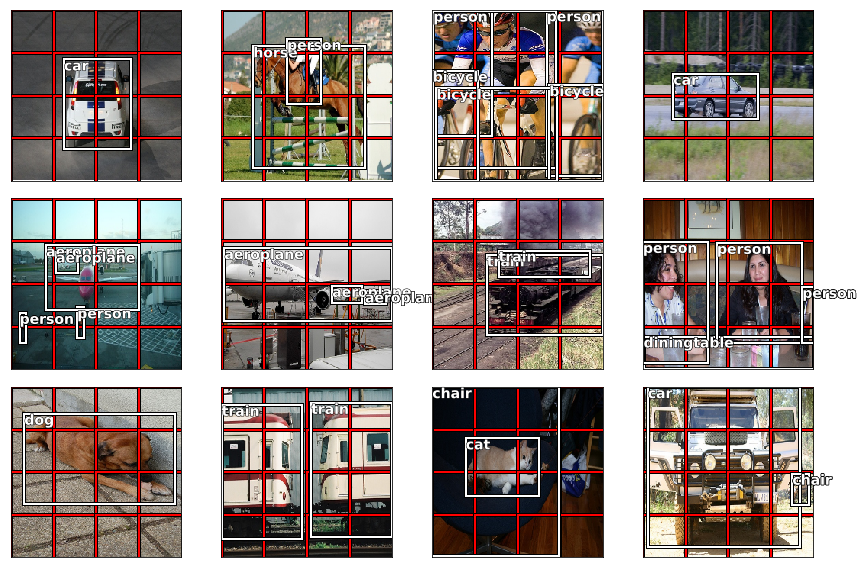

In [12]:
plot_multiple(dataset)

In [13]:
len(dataset.get_annotations())

2501

In [14]:
image_id, im, gt_bbs, gt_cats = dataset[1]
image_id, im.shape, gt_bbs.shape, gt_cats.shape

(17, (3, 224, 224), (16, 4), (16, 20))

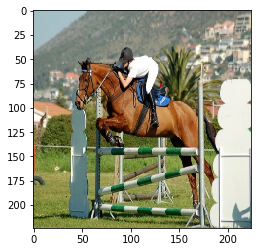

In [15]:
hwc_im = np.transpose(im, (1,2,0))
plt.imshow(hwc_im)

In [16]:
gt_idx = np.where(gt_cats == 1)[0]
gt_idx

array([5, 7])

In [17]:
gt_idx_bbs = gt_bbs[gt_idx]
gt_idx_bbs

array([[ 47.38461538461539,  41.53333333333333, 205.76923076923077, 187.06666666666666],
       [ 37.53846153846153,  85.86666666666667, 121.46153846153845, 129.20000000000002]])

In [18]:
np.argmax(gt_cats, axis=1)

array([ 0,  0,  0,  0,  0, 12,  0, 14,  0,  0,  0,  0,  0,  0,  0,  0])

In [19]:
gt_idx_cats = np.argmax(gt_cats, axis=1)[gt_idx]
gt_idx_cats

array([12, 14])

In [20]:
image_id

17

In [21]:
dataset.images()[image_id]

'//Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/JPEGImages/000017.jpg'

In [22]:
for bb, cat in zip(gt_idx_bbs, gt_idx_cats):
    print(bb, cat)

[ 47.38461538461539  41.53333333333333 205.76923076923077 187.06666666666666] 12
[ 37.53846153846153  85.86666666666667 121.46153846153845 129.20000000000002] 14


In [23]:
dataset.categories()[12]

'horse'

In [24]:
hwc_im.shape

(224, 224, 3)

In [25]:
def bb_hw(a):
    return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

bb_hw(gt_idx_bbs[0])

array([ 41.53333333333333,  47.38461538461539, 146.53333333333333, 159.3846153846154 ])

In [26]:
def bb_hws(a):
    return np.array([a[:,1],a[:,0],a[:,3]-a[:,1]+1,a[:,2]-a[:,0]+1]).T

bb_hws(gt_idx_bbs)

array([[ 41.53333333333333,  47.38461538461539, 146.53333333333333, 159.3846153846154 ],
       [ 85.86666666666667,  37.53846153846153,  44.33333333333334,  84.92307692307692]])

In [27]:
gt_idx_bbs

array([[ 47.38461538461539,  41.53333333333333, 205.76923076923077, 187.06666666666666],
       [ 37.53846153846153,  85.86666666666667, 121.46153846153845, 129.20000000000002]])

# matplotlib helpers

In [28]:
def show_img(im, figsize=None, ax=None):
    if not ax:
        fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_rect(ax, b, edgecolor='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=edgecolor, lw=2))
    draw_outline(patch, 4)
    
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

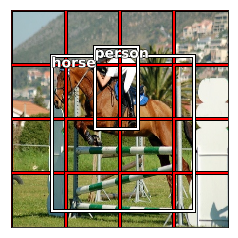

In [29]:
resized_image = hwc_im
ax = show_img(resized_image)
for bbox in dataset.bboxer.anchor_corners():
    draw_rect(ax, bbox*224, edgecolor='red')
for bbox, cat in zip(bb_hws(gt_idx_bbs), gt_idx_cats):
    draw_rect(ax, bbox)
    draw_text(ax, bbox[:2], dataset.categories()[cat])

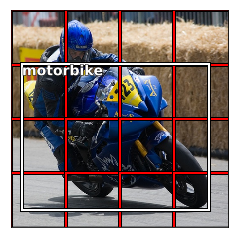

In [30]:
import random

def plot_single(dataset, idx, ax=None):
    "uses the Dataset idx to select a training sample and plot it"
    image_id, im, gt_bbs, gt_cats = dataset[idx]
    gt_idx = np.where(gt_cats == 1)[0]
    gt_idx_bbs = gt_bbs[gt_idx]
    gt_idx_cats = np.argmax(gt_cats, axis=1)[gt_idx]

    resized_image = np.transpose(im, (1,2,0))
    ax = show_img(resized_image, ax=ax)
    for bbox in dataset.bboxer.anchor_corners():
        draw_rect(ax, bbox*224, edgecolor='red')
    for bbox, cat in zip(dataset.bboxer.pascal_bbs(gt_idx_bbs), gt_idx_cats):
        draw_rect(ax, bbox)
        draw_text(ax, bbox[:2], dataset.categories()[cat])
        
idx = random.randint(0,100)
plot_single(dataset, idx)

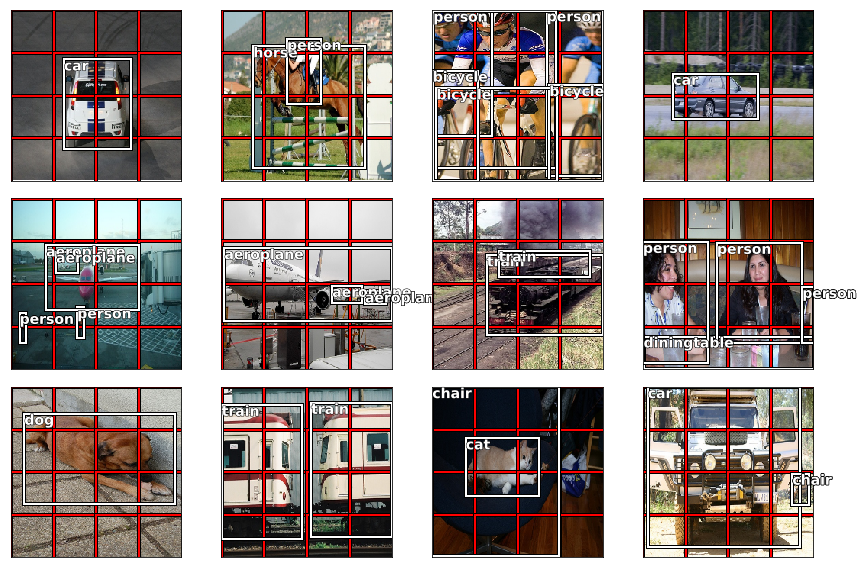

In [31]:
def plot_multiple(dataset):
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i,ax in enumerate(axes.flat):
        plot_single(dataset, i, ax)
    plt.tight_layout()

plot_multiple(dataset)

## Next: run Model training loop

- need a custom head - from the Resnet18 bottleneck output to the expected prediction format
- need a loss function

In [1]:
# ax = show_img(hwc_im)
# for bbox, cat in ann[image_id]:
#     draw_rect(ax, bbox)
#     draw_text(ax, bbox[:2], categories[cat])

In [2]:
# def get_gt_bbs_and_cats(self, bbs, cats, im):
im = hwc_im

ann = dataset.get_annotations()[image_id]
bbs = ann['bbs']
cats = ann['cats']

gt_overlap, gt_idx = dataset.bboxer.get_gt_overlap_and_idx(bbs, im)
bbs = dataset.bboxer.scaled_fastai_bbs(bbs, im)
cats = np.array(cats)
# neg_idx = np.nonzero(1-gt_idx)[:,0]
# clas_cats = cats[gt_idx]
gt_bbs = bbs[gt_idx]
gt_cats = cats[gt_idx]

gt_bbs.shape, gt_cats.shape

NameError: name 'hwc_im' is not defined

In [ ]:
gt_idx

In [ ]:
ann = dataset.get_annotations()[image_id]
bbs = ann['bbs']
bbs

In [ ]:
cats = ann['cats']
cats

In [ ]:
im.shape

In [ ]:
bbs

In [ ]:
gt_overlap

In [ ]:
thresh = 0.5
pos = gt_overlap > thresh
# pos_idx = np.nonzero(pos)[:,0]
neg_idx = np.nonzero(1-pos)[:,0]
# pos_idx

In [ ]:
gt_cats[neg_idx] = 20
gt_cats

In [ ]:
grid_size = 4
num_classes = 21

onehot = np.zeros((16, 21))
onehot.shape

In [ ]:
a = np.array([
    [1,2,3],
    [4,5,6]
])

a[[0],[1]]

In [ ]:
x = np.arange(16*21).reshape(16,21)
x

In [ ]:
gt_cats

In [ ]:
num_classes = 21
onehot = np.eye(num_classes)[gt_cats]
onehot

In [ ]:
onehot.shape

In [ ]:
onehot[:,:-1].shape

In [ ]:
onehot[:,:-1]

In [ ]:
x[np.array([0,1]), 1]

In [ ]:
b = np.array([1,2])
np.eye(3)[b]

In [ ]:
onehot[0][]

In [ ]:
np.where(onehot[0] == 1)[0]

In [ ]:
onehot

In [ ]:
gt_overlap

In [ ]:
gt_cats

In [ ]:
cats_list = [x['name'] for x in dataset.data()[CATEGORIES]]
cats_list.append('bg')

categories = np.array(cats_list)
categories

In [ ]:
cats_dict = {i:c for i,c in enumerate(categories)}

In [ ]:
list(cats_dict.keys())

In [ ]:
gt_cats[neg_idx] = 20
gt_cats

In [ ]:
gt_cats[pos_idx]

In [ ]:
pos_idx

## dense category encoding

In [ ]:
hwc_im = np.transpose(im, (1,2,0))
im = hwc_im

ann = dataset.get_annotations()[image_id]
bbs = ann['bbs']
cats = ann['cats']
gt_overlap, gt_idx = dataset.bboxer.get_gt_overlap_and_idx(bbs, im)
bbs = dataset.bboxer.scaled_fastai_bbs(bbs, im)
cats = np.array(cats)
neg_idx = np.nonzero(1-gt_idx)[:,0]
clas_cats = cats[gt_idx]
gt_bbs = bbs[gt_idx]
gt_cats = cats[gt_idx]

thresh = 0.5
pos = gt_overlap > thresh
pos_idx = np.nonzero(pos)[:,0]
neg_idx = np.nonzero(1-pos)[:,0]
pos_idx

gt_cats[neg_idx] = 20
gt_cats

In [ ]:
categories[gt_cats]

In [ ]:
lst(categories